# Analysis with Validation Data

In [4]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [33]:
path1 = '../../../data/'

def evaluate_channel(channel, inputs, targets):
    d = channel.d
    N = inputs[0].shape[0]
    kl_div = KLDiv()
    loss = kl_div(channel, inputs, targets)/N
    return np.real(loss)


def calculate_channel_fittness(model_name, num_layers = None):
    model_list = loader("data/" + model_name)
    reps = len(model_list)//3
    
    d = model_list[0].channel.d
    n = int(np.log2(d))

    U_circuit_list = []

    R_fid_list = []

    U_fid_list = []

    T_concat_fid_list = []
    T_fid_list = []

    np.random.seed(42)
    random.seed(42)

    
    
    for i in tqdm(range(reps)):

        circuit1 = pqc_basic(n, num_layers)


        circuit2 = pqc_basic(n, num_layers)


        circuit3 = deepcopy(circuit1)
        circuit3 = circuit3.compose(circuit2)
        U = circuit_to_matrix(circuit3)
        U_circuit_list.append(U)

        #Throw-away computation to advance RNG correctly
        circuit_target_list = [circuit1, circuit2, circuit3]
        belem_concatenate = ExecuteAndCollect()
        belem_concatenate.setup_circuits(circuit_target_list, N_map = 2000-6**n)
   

    for i in range(reps):
        
        model1 = model_list[3*i]
        model2 = model_list[3*i+1]
        model3 = model_list[3*i+2]

        inputs_val, targets_val = model3.inputs_val, model3.targets_val

        channel1 = model1.channel
        channel2 = model2.channel
        channel3 = model3.channel

        channel_concat = channel_to_choi_map([channel1, channel2])
        channel_concat.spam = channel3.spam

        U_channel3 = ChoiMapStatic(U_circuit_list[i], mode="unitary")
        U_channel3.spam = channel3.spam

        identity_channel = IdentityChannel(d)
        identity_channel.spam = channel3.spam

        R_fid_list.append(evaluate_channel(identity_channel, inputs_val, targets_val)) 
        U_fid_list.append(evaluate_channel(U_channel3, inputs_val, targets_val))

        T_concat_fid_list.append(evaluate_channel(channel_concat, inputs_val, targets_val))
        T_fid_list.append(evaluate_channel(channel3, inputs_val, targets_val))
        
    
    
    Id_fid_mean = np.mean(R_fid_list)  
    Id_fid_std = np.std(R_fid_list)  
    
    U_fid_mean = np.mean(U_fid_list)  
    U_fid_std = np.std(U_fid_list)  
    
    T_concat_fid_mean = np.mean(T_concat_fid_list)
    T_concat_fid_std = np.std(T_concat_fid_list)
    
    T_fid_mean = np.mean(T_fid_list)
    T_fid_std = np.std(T_fid_list)
    
    mean_list = [Id_fid_mean, U_fid_mean, T_concat_fid_mean, T_fid_mean]
    std_list = [Id_fid_std, U_fid_std, T_concat_fid_std, T_fid_std]

    
    return mean_list, std_list

## KL Divergence with Respect to Real Data

In [34]:
mean_list1, std_list1 = calculate_channel_fittness(model_name="belem_concatenate_2layer_fitted_validation.model", 
                                                   num_layers = 2)

  0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
Id_fid_mean, U_fid_mean, T_concat_fid_mean, T_fid_mean = mean_list1
Id_fid_std, U_fid_std, T_concat_fid_std, T_fid_std = std_list1

print(f"Id KL-Div: {Id_fid_mean:.5f} +-{Id_fid_std:.5f}")

print("----")
print(f"U KL-Div: {U_fid_mean:.5f} +-{U_fid_std:.5f}")

print("----")
print(f"T_concat KL-Div: {T_concat_fid_mean:.5f} +-{T_concat_fid_std:.5f}")

print("----")
print(f"T KL-Div: {T_fid_mean:.5f} +-{T_fid_std:.5f}")


Id KL-Div: 0.00601 +-0.00054
----
U KL-Div: 0.00083 +-0.00008
----
T_concat KL-Div: 0.00027 +-0.00003
----
T KL-Div: 0.00007 +-0.00001


In [38]:
mean_list2, std_list2 = calculate_channel_fittness(model_name="belem_concatenate_4layer_fitted_validation.model",
                                                   num_layers = 4)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
Id_fid_mean, U_fid_mean, T_concat_fid_mean, T_fid_mean = mean_list2
Id_fid_std, U_fid_std, T_concat_fid_std, T_fid_std = std_list2

print(f"Id KL-Div: {Id_fid_mean:.5f} +-{Id_fid_std:.5f}")

print("----")
print(f"U KL-Div: {U_fid_mean:.5f} +-{U_fid_std:.5f}")

print("----")
print(f"T_concat KL-Div: {T_concat_fid_mean:.5f} +-{T_concat_fid_std:.5f}")

print("----")
print(f"T KL-Div: {T_fid_mean:.5f} +-{T_fid_std:.5f}")


Id KL-Div: 0.00578 +-0.00035
----
U KL-Div: 0.00095 +-0.00007
----
T_concat KL-Div: 0.00025 +-0.00011
----
T KL-Div: 0.00006 +-0.00000


In [ ]:
mean_list3, std_list3 = calculate_channel_fittness(model_name="belem_concatenate_6layer_fitted_validation.model",
                                                   num_layers = 6)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
Id_fid_mean, U_fid_mean, T_concat_fid_mean, T_fid_mean = mean_list3
Id_fid_std, U_fid_std, T_concat_fid_std, T_fid_std = std_list3

print(f"Id KL-Div: {Id_fid_mean:.5f} +-{Id_fid_std:.5f}")

print("----")
print(f"U KL-Div: {U_fid_mean:.5f} +-{U_fid_std:.5f}")

print("----")
print(f"T_concat KL-Div: {T_concat_fid_mean:.5f} +-{T_concat_fid_std:.5f}")

print("----")
print(f"T KL-Div: {T_fid_mean:.5f} +-{T_fid_std:.5f}")



Id KL-Div: 0.00511 +-0.00035
----
U KL-Div: 0.00145 +-0.00007
----
T_concat KL-Div: 0.00009 +-0.00011
----
T KL-Div: 0.00004 +-0.00000


In [ ]:
mean_list4, std_list4 = calculate_channel_fittness(model_name="belem_concatenate_8layer_fitted_validation.model",
                                                   num_layers = 8)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
Id_fid_mean, U_fid_mean, T_concat_fid_mean, T_fid_mean = mean_list4
Id_fid_std, U_fid_std, T_concat_fid_std, T_fid_std = std_list4

print(f"Id KL-Div: {Id_fid_mean:.5f} +-{Id_fid_std:.5f}")

print("----")
print(f"U KL-Div: {U_fid_mean:.5f} +-{U_fid_std:.5f}")

print("----")
print(f"T_concat KL-Div: {T_concat_fid_mean:.5f} +-{T_concat_fid_std:.5f}")

print("----")
print(f"T KL-Div: {T_fid_mean:.5f} +-{T_fid_std:.5f}")



Id KL-Div: 0.00556 +-0.00033
----
U KL-Div: 0.00125 +-0.00010
----
T_concat KL-Div: 0.00014 +-0.00001
----
T KL-Div: 0.00005 +-0.00001


In [ ]:
mean_list = np.array([mean_list1, mean_list2, mean_list3, mean_list4])
std_list = np.array([std_list1, std_list2, std_list3, std_list4])

In [ ]:
np.savetxt("data/concatenation_highRankModel_meanKLDiv_validation.txt", mean_list, fmt='%f')
np.savetxt("data/concatenation_highRankModel_stdKLDiv_validation.txt", std_list, fmt='%f')

## Unitary Models

In [ ]:
def calculate_channel_fittness(model_name):
    model_list = loader("data/" + model_name)
    reps = len(model_list)
    
    d = model_list[0].channel.d

    U_fid_list = []

    np.random.seed(42)
    random.seed(42)
   

    for i in range(reps):
        
        model = model_list[i]
  

        inputs_val, targets_val = model.inputs_val, model.targets_val

        channel = model.channel
 


        U_fid_list.append(evaluate_channel(channel, inputs_val, targets_val))  
    
    U_fid_mean = np.mean(U_fid_list)  
    U_fid_std = np.std(U_fid_list)  

    
    return U_fid_mean, U_fid_std

In [ ]:
mean_list5, std_list5 = calculate_channel_fittness(model_name="belem_concatenate_2layer_fitted_unitary_validation.model")

mean_list6, std_list6 = calculate_channel_fittness(model_name="belem_concatenate_4layer_fitted_unitary_validation.model")

mean_list7, std_list7 = calculate_channel_fittness(model_name="belem_concatenate_6layer_fitted_unitary_validation.model")

mean_list8, std_list8 = calculate_channel_fittness(model_name="belem_concatenate_8layer_fitted_unitary_validation.model")

In [ ]:
U_mean_list = np.array([mean_list5, mean_list6, mean_list7, mean_list8])
U_std_list = np.array([std_list5, std_list6, std_list7, std_list8])

In [ ]:
mean_list = np.loadtxt("data/concatenation_highRankModel_meanKLDiv_validation.txt")
std_list = np.loadtxt("data/concatenation_highRankModel_stdKLDiv_validation.txt")

U_mean_list = np.loadtxt("data/concatenation_highRankModel_meanKLDiv_unitary_validation.txt")
U_std_list = np.loadtxt("data/concatenation_highRankModel_stdKLDiv_unitary_validation.txt")

mean_list = np.insert(mean_list, 2, U_mean_list, axis=1)
std_list = np.insert(std_list, 2, U_std_list, axis=1)

In [ ]:
np.savetxt("data/concatenation_validation_mean.txt", mean_list, fmt='%f')
np.savetxt("data/concatenation_validation_std.txt", std_list, fmt='%f')

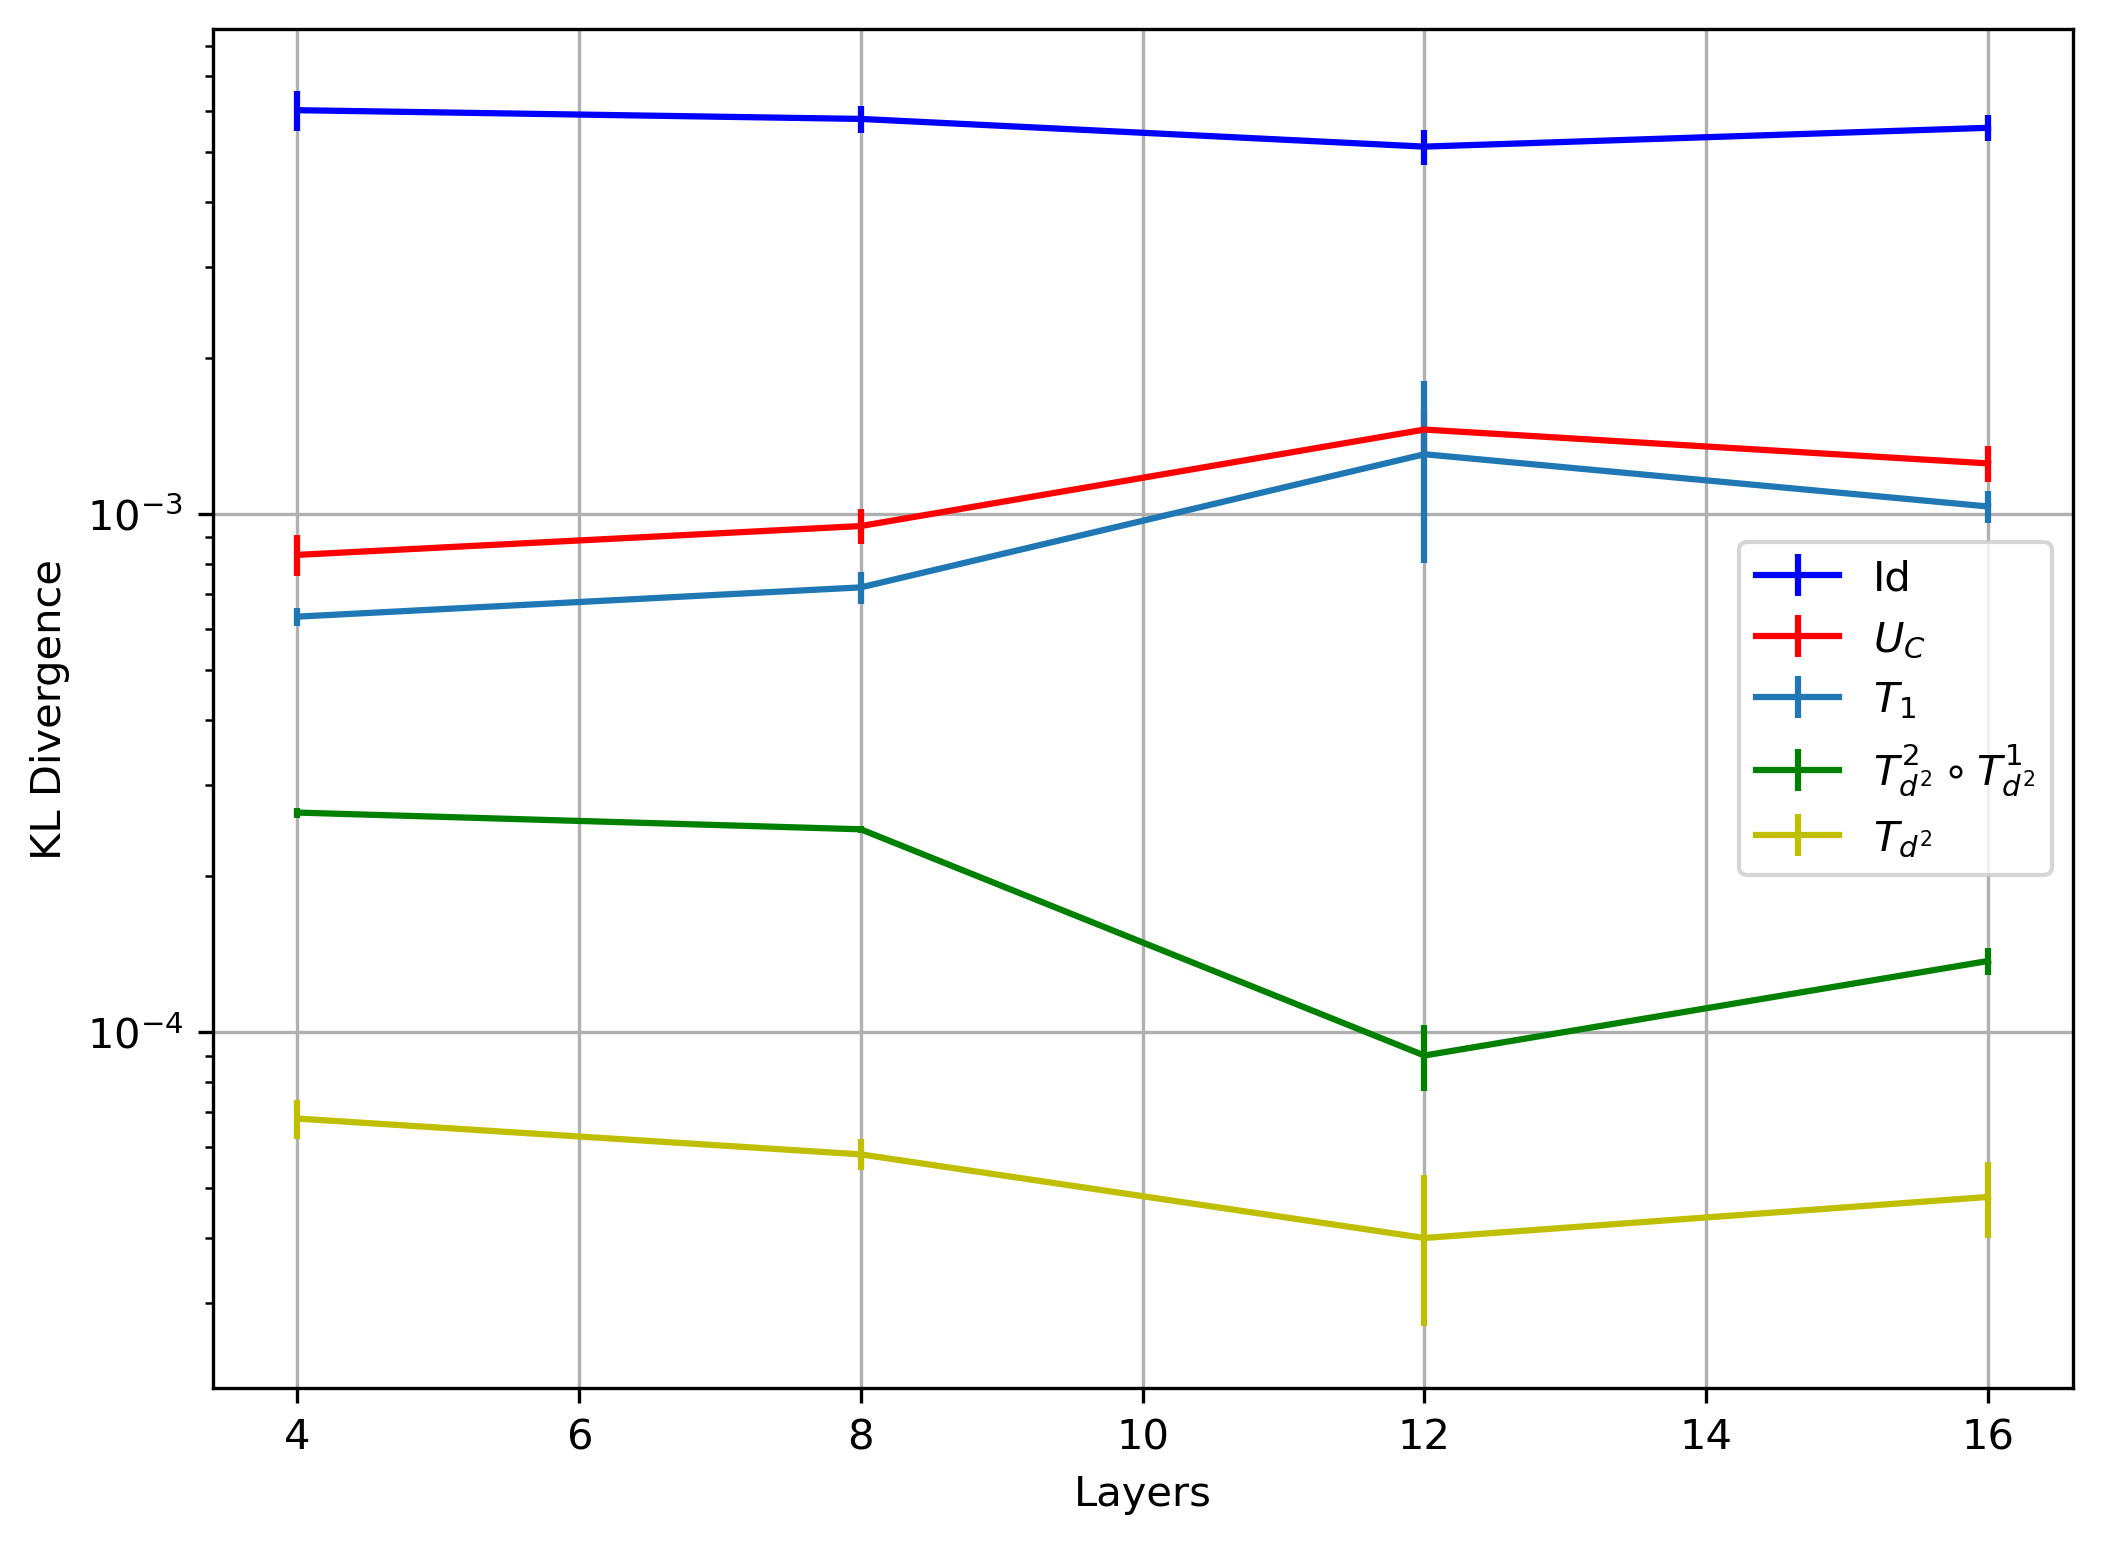

In [ ]:
mean_list = np.loadtxt("data/concatenation_validation_mean.txt")
std_list = np.loadtxt("data/concatenation_validation_std.txt")

x = [4, 8, 12, 16]
fig = plt.figure(figsize=(8,6), dpi = 300, facecolor='w', edgecolor='k')

plt.errorbar(x, mean_list[:,0], yerr = std_list[:,0], fmt = "b-")
plt.errorbar(x, mean_list[:,1], yerr = std_list[:,1], fmt = "r-")
plt.errorbar(x, mean_list[:,2], yerr = std_list[:,2])
plt.errorbar(x, mean_list[:,3], yerr = std_list[:,3], fmt = "g-")
plt.errorbar(x, mean_list[:,4], yerr = std_list[:,4], fmt = "y-")

plt.legend(["Id", "$U_C$", "$T_1$", "$T_{d^2}^2 \circ T_{d^2}^1$", "$T_{d^2}$"])
plt.yscale("log")
plt.xlabel("Layers")
#plt.ylim([1e-6, 1e-3])
plt.ylabel("KL Divergence")
plt.grid()
plt.savefig("figures/concatenation_highRankModel.pdf")
plt.show()